# Exploratory Data Analysis

Suicide is a critical public health problem in the United States (US). It's the 10th leading cause of death in the nation and the 2nd leading cause of death among US veterans. Since 2012, national suicide surveillance systems have documented that nearly 70% of suicides in veterans are committed by older veterans who are at least 50 years old. Although there's a growing body of academic research about the risk factors of suicide, data has consistently shown that a prior suicide attempt is one of the strongest risk factors of a future suicide attempt. However, in spite of continuing research about this, it seems that health care providers still don't know whether a patient with those risk factors will try to commit suicide. Suicide is preventable, and I believe that having a tool that can help predict a suicide attempt is important for aiding health care providers in saving lives. I was curious to see whether we could build a model to do that. 

The goal of this project is to build a model to predict whether a veteran who has previously attempted to commit suicide (but failed) will try to commit suicide again (i.e., a repeated suicide attempt). Using electronic health record (EHR) data provided by the US Department of Veterans Affairs for fiscal years 2013 - 2014, we begin by exploring the data to understand the features and patterns. Because feature names include both upper- and lowercase strings, we lowercase them to make the features easier to work with.

In [2]:
# import libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import functions as func

In [3]:
# load data 
df = pd.read_csv('~/Desktop/repeat_suicide_attempt_full.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8006 entries, 0 to 8005
Data columns (total 82 columns):
ScrSSN                           8006 non-null int64
dod_csrd                         1765 non-null object
bl_1stattempt_date               8006 non-null object
repeat_attempt_date              1485 non-null object
repeat_suicide_date              155 non-null object
repeat_attempt_1stdate           1569 non-null object
oneyear_after_1stattempt         8006 non-null object
repeat_attempt_within_oneyear    8006 non-null int64
mortality_before_repeat          8006 non-null int64
ALCOHOL_com_new                  8006 non-null int64
ALS_com_new                      8006 non-null int64
anxiety_com_new                  8006 non-null int64
anydem_com_new                   8006 non-null int64
BIPOLAR_com_new                  8006 non-null int64
cancer_com_new                   8006 non-null int64
cerebrovascular_com_new          8006 non-null int64
chf_com_new                      8006 no

In [4]:
# lowercase column names 
df.columns = df.columns.str.lower()

# Patients

The dataset includes roughly 8,000 older veterans who all have had a prior suicide attempt. The majority of these veterans are white men. Because we're interested in predicting who will have a repeated suicide attempt, everyone in the dataset should be alive so we remove those who have already died. This leaves us with around 7,700 veterans.

In [5]:
# exclude veterans who died
print(df['mortality_before_repeat'].value_counts())
df = df[df['mortality_before_repeat'] == 0]
print(df.shape)

0    7698
1     308
Name: mortality_before_repeat, dtype: int64
(7698, 82)


In [6]:
# inspect data
df.describe()

,scrssn,repeat_attempt_within_oneyear,mortality_before_repeat,alcohol_com_new,als_com_new,anxiety_com_new,anydem_com_new,bipolar_com_new,cancer_com_new,cerebrovascular_com_new,...,age_group_cat2,gender,race_csrd_4cat,race_csrd_4cat_v2,race_csrd_3cat,ms_csrd_5cat,ms_csrd_4cat,ms_csrd_2cat,comorbidity_index,comorbidity_index_any
count,7.698000e+03,7698.000000,7698.0,7698.000000,7698.0,7698.000000,7698.000000,7698.000000,7698.000000,7698.000000,...,7698.000000,7698.000000,7698.000000,7698.000000,7698.000000,7698.000000,7638.000000,7698.000000,7698.000000,7698.000000
mean,5.043847e+08,0.145752,0.0,0.091842,0.0,0.088724,0.026241,0.053390,0.024682,0.030398,...,1.164848,0.911276,1.371655,1.395947,1.327618,1.996752,1.973161,0.334373,1.552481,0.609379
std,2.859401e+08,0.352880,0.0,0.288822,0.0,0.284364,0.159860,0.224826,0.155163,0.171690,...,0.371067,0.284364,0.744448,0.810573,0.603974,0.899881,0.862977,0.471801,1.793601,0.487921
min,6.149700e+04,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.603130e+08,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,5.061498e+08,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,0.000000,1.000000,1.000000
75%,7.500244e+08,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,2.000000,2.000000,2.000000,3.000000,3.000000,1.000000,2.000000,1.000000
max,9.998969e+08,1.000000,0.0,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,...,2.000000,1.000000,4.000000,4.000000,3.000000,5.000000,4.000000,1.000000,6.000000,1.000000


In [7]:
df.head()

,scrssn,dod_csrd,bl_1stattempt_date,repeat_attempt_date,repeat_suicide_date,repeat_attempt_1stdate,oneyear_after_1stattempt,repeat_attempt_within_oneyear,mortality_before_repeat,alcohol_com_new,...,age_group_cat2,gender,race_csrd_4cat,race_csrd_4cat_v2,race_csrd_3cat,ms_csrd_5cat,ms_csrd_4cat,ms_csrd_2cat,comorbidity_index,comorbidity_index_any
0,61497,NaN,06/10/2013,08/02/2013,NaN,08/02/2013,06/10/2014,1,0,0,...,1,1,1,1,1,1,1.0,1,4,1
2,234487,09/17/2017,04/08/2012,NaN,NaN,NaN,04/08/2013,0,0,0,...,1,1,1,1,1,1,1.0,1,5,1
3,234801,05/03/2016,12/16/2011,NaN,NaN,NaN,12/16/2012,0,0,0,...,1,1,1,1,1,1,1.0,1,1,1
4,408146,NaN,04/19/2012,09/07/2014,NaN,09/07/2014,04/19/2013,0,0,0,...,1,1,1,1,1,3,3.0,0,1,1
5,433701,04/24/2014,04/21/2013,NaN,NaN,NaN,04/21/2014,0,0,0,...,2,1,1,1,1,2,2.0,0,2,1


In [8]:
df.tail()

,scrssn,dod_csrd,bl_1stattempt_date,repeat_attempt_date,repeat_suicide_date,repeat_attempt_1stdate,oneyear_after_1stattempt,repeat_attempt_within_oneyear,mortality_before_repeat,alcohol_com_new,...,age_group_cat2,gender,race_csrd_4cat,race_csrd_4cat_v2,race_csrd_3cat,ms_csrd_5cat,ms_csrd_4cat,ms_csrd_2cat,comorbidity_index,comorbidity_index_any
8001,999191590,NaN,06/02/2012,NaN,NaN,NaN,06/02/2013,0,0,0,...,1,1,1,1,1,2,2.0,0,0,0
8002,999258263,NaN,07/26/2012,NaN,NaN,NaN,07/26/2013,0,0,0,...,1,1,1,1,1,2,2.0,0,1,1
8003,999408503,05/05/2016,06/30/2012,NaN,NaN,NaN,06/30/2013,0,0,0,...,1,1,1,1,1,1,1.0,1,0,0
8004,999864867,12/19/2017,10/28/2011,12/16/2012,NaN,12/16/2012,10/28/2012,0,0,0,...,2,1,1,1,1,1,1.0,1,6,1
8005,999896870,NaN,05/09/2012,NaN,NaN,NaN,05/09/2013,0,0,0,...,1,1,1,1,1,1,1.0,1,2,1


## Inspect features with many unique values

Based on the features in the dataset, there seems to be features that may not help us predict a repeat suicide attempt. These features include dates, scrambled social security numbers, and zip codes. Because these features have a lot of unique values where there are often not enough cases of each value to give those features much predictive ability, we drop these features.

In [9]:
# get types of features
date_feats = func.get_feats('date', df)
disorder_feats = func.get_feats('new', df)
other_feats = list(filter(lambda col: 'date' not in col and 'new' not in col, df.columns))

for name,feat in zip(['date_feats', 'disorder_feats', 'other_feats'], [date_feats, disorder_feats, other_feats]):
    print('{feat_type}: {feats}'.format(feat_type = name, feats = feat))
    print('\n')

date_feats: ['bl_1stattempt_date', 'repeat_attempt_date', 'repeat_suicide_date', 'repeat_attempt_1stdate']


disorder_feats: ['alcohol_com_new', 'als_com_new', 'anxiety_com_new', 'anydem_com_new', 'bipolar_com_new', 'cancer_com_new', 'cerebrovascular_com_new', 'chf_com_new', 'chronicpain_com_new', 'circulatory_com_new', 'copd_com_new', 'csrdtbi_com_new', 'csrdtbi_mild_com_new', 'csrdtbi_mod_com_new', 'depnos_com_new', 'depression_com_new', 'dm_com_new', 'drug_com_new', 'dys_com_new', 'epilepsy_com_new', 'gad_com_new', 'gastrointestinal_com_new', 'hepa_com_new', 'hepatitis_com_new', 'hepb_com_new', 'hepc_com_new', 'hiv_com_new', 'hyperten_com_new', 'liverdis_com_new', 'major_dep_com_new', 'mi_com_new', 'mooddis_com_new', 'ms_com_new', 'obesity_com_new', 'ocd_com_new', 'overwt_com_new', 'pain_com_new', 'panic_com_new', 'pd_com_new', 'perdis_com_new', 'phobic_com_new', 'pneumonia_com_new', 'psychosis_com_new', 'ptsd_com_new', 'pvd_com_new', 'renaldis_com_new', 'schiz_com_new', 'sleepissue

In [10]:
df.loc[:, date_feats].head()

,bl_1stattempt_date,repeat_attempt_date,repeat_suicide_date,repeat_attempt_1stdate
0,06/10/2013,08/02/2013,NaN,08/02/2013
2,04/08/2012,NaN,NaN,NaN
3,12/16/2011,NaN,NaN,NaN
4,04/19/2012,09/07/2014,NaN,09/07/2014
5,04/21/2013,NaN,NaN,NaN


In [11]:
df.loc[:, other_feats].head()

,scrssn,dod_csrd,oneyear_after_1stattempt,repeat_attempt_within_oneyear,mortality_before_repeat,zip,ms,sex,vha_user,race_csrd,...,age_group_cat2,gender,race_csrd_4cat,race_csrd_4cat_v2,race_csrd_3cat,ms_csrd_5cat,ms_csrd_4cat,ms_csrd_2cat,comorbidity_index,comorbidity_index_any
0,61497,NaN,06/10/2014,1,0,59804.0,M,M,1,1,...,1,1,1,1,1,1,1.0,1,4,1
2,234487,09/17/2017,04/08/2013,0,0,27581.0,M,M,1,1,...,1,1,1,1,1,1,1.0,1,5,1
3,234801,05/03/2016,12/16/2012,0,0,16055.0,M,M,1,1,...,1,1,1,1,1,1,1.0,1,1,1
4,408146,NaN,04/19/2013,0,0,39577.0,S,M,1,1,...,1,1,1,1,1,3,3.0,0,1,1
5,433701,04/24/2014,04/21/2014,0,0,16508.0,D,M,1,1,...,2,1,1,1,1,2,2.0,0,2,1


In [12]:
all(df['sex'].map({'M': 1, 'F': 0}) == df['gender'])

True

## Inspect features with multiple variations

Furthermore, there are multiple features about race-ethnicity and marital status. Because including all these features would be redundant and introduce collinearity issues, we examine each feature to determine which ones would be the most appropriate to use.

### Race
The features 'race_csrd_3cat' and 'race_csrd_4cat' look promising. Other features such as 'race_csrd' and 'race_csrd_4cat_v2' have very few cases for specific levels such as Hispanic. These features may pose problems because they may not contain enough cases per level to learn the appropriate weights.

### Marital status
The feature 'ms_csrd_5cat' also looks good. It captures granularity about marital status that could be important for prediction. Other features like 'ms_csrd_7cat' contains 7 levels, of which several have relatively few cases while 'ms_csrd_4cat' has a number of missing values. The feature 'ms_csrd_2cat' could be an alternative option though it captures less granularity than 'ms_csrd_5cat'.

In [13]:
# insepct race-related features
race_feats = func.get_feats('race', df)
df.loc[:, race_feats].head()

,race_csrd,race_csrd_4cat,race_csrd_4cat_v2,race_csrd_3cat
0,1,1,1,1
2,1,1,1,1
3,1,1,1,1
4,1,1,1,1
5,1,1,1,1


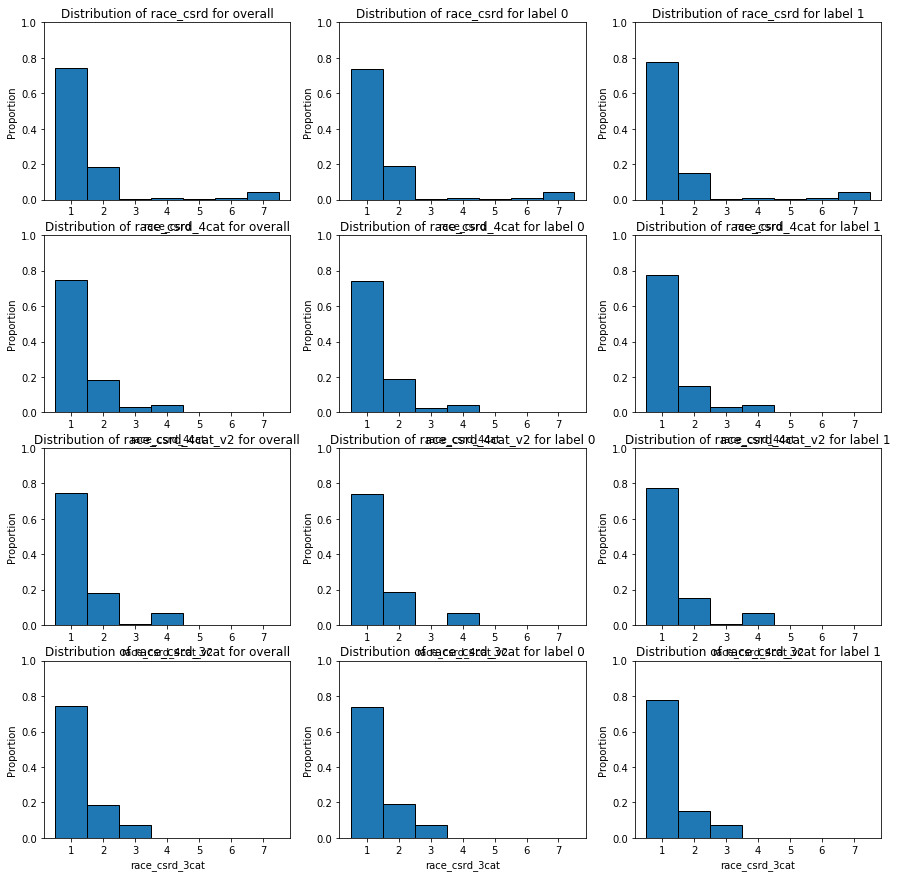

In [14]:
# see distributions
func.plot_feats(race_feats, bins = np.arange(.5,8,1), df = df)

In [15]:
# check frequencies
func.get_distribution(race_feats, df)

1    5732
2    1410
7     339
4      87
6      72
3      30
5      28
Name: race_csrd, dtype: int64
1    0.745
2    0.183
7    0.044
4    0.011
6    0.009
3    0.004
5    0.004
Name: race_csrd, dtype: float64


1    5732
2    1410
4     339
3     217
Name: race_csrd_4cat, dtype: int64
1    0.745
2    0.183
4    0.044
3    0.028
Name: race_csrd_4cat, dtype: float64


1    5732
2    1410
4     526
3      30
Name: race_csrd_4cat_v2, dtype: int64
1    0.745
2    0.183
4    0.068
3    0.004
Name: race_csrd_4cat_v2, dtype: float64


1    5732
2    1410
3     556
Name: race_csrd_3cat, dtype: int64
1    0.745
2    0.183
3    0.072
Name: race_csrd_3cat, dtype: float64




In [14]:
# inspect marital status-related features 
ms_feats = func.get_feats('ms', df)
df.loc[:, ms_feats].head()

,ms_com_new,ms,ms_csrd_5cat,ms_csrd_4cat,ms_csrd_2cat
0,0,M,1,1.0,1
2,0,M,1,1.0,1
3,0,M,1,1.0,1
4,0,S,3,3.0,0
5,0,D,2,2.0,0


In [17]:
# check marital status 
df['ms'].value_counts()

D    3070
M    2574
N    1117
S     502
W     375
U      60
Name: ms, dtype: int64

In [15]:
# recode marital status 
df['ms_csrd_7cat'] = df['ms'].map({'M':1, 'A':2, 'D':3, 'W':4, 'N':5, 'S':6, 'U':7})
df['ms_csrd_7cat'].value_counts()

3    3070
1    2574
5    1117
6     502
4     375
7      60
Name: ms_csrd_7cat, dtype: int64

In [ ]:
func.plot_feats(ms_feats[1:], bins = np.arange(-.5,8,1), df = df)

In [19]:
# check frequencies
func.get_distribution(ms_feats[2:], df)

2    3070
1    2574
3    1619
4     375
5      60
Name: ms_csrd_5cat, dtype: int64
2    0.399
1    0.334
3    0.210
4    0.049
5    0.008
Name: ms_csrd_5cat, dtype: float64


2.0    3070
1.0    2574
3.0    1619
4.0     375
Name: ms_csrd_4cat, dtype: int64
2.0    0.402
1.0    0.337
3.0    0.212
4.0    0.049
Name: ms_csrd_4cat, dtype: float64


0    5124
1    2574
Name: ms_csrd_2cat, dtype: int64
0    0.666
1    0.334
Name: ms_csrd_2cat, dtype: float64




## Inspect features about disorders 

Because the majority of our features are binary variables about psychiatric and medical disorders, we inspect them to make sure they contain sufficient number of cases. Most of these features seem ok. There may be some correlation between features like major depression and mood disorder, as major depression is a psychiatric disorder that is one of the most common types of mood disorders. Furthermore, there are several medical disorders like 'hiv_com_new' that seem to have lower variability while 'als_com_new' has no variability (i.e., only has a single value). Because 'als_com_new' has no predictive ability, we drop this feature.

In [13]:
# check frequencies
func.get_distribution(disorder_feats, df)

0    6991
1     707
Name: alcohol_com_new, dtype: int64
0    0.908
1    0.092
Name: alcohol_com_new, dtype: float64


0    7698
Name: als_com_new, dtype: int64
0    1.0
Name: als_com_new, dtype: float64


0    7015
1     683
Name: anxiety_com_new, dtype: int64
0    0.911
1    0.089
Name: anxiety_com_new, dtype: float64


0    7496
1     202
Name: anydem_com_new, dtype: int64
0    0.974
1    0.026
Name: anydem_com_new, dtype: float64


0    7287
1     411
Name: bipolar_com_new, dtype: int64
0    0.947
1    0.053
Name: bipolar_com_new, dtype: float64


0    7508
1     190
Name: cancer_com_new, dtype: int64
0    0.975
1    0.025
Name: cancer_com_new, dtype: float64


0    7464
1     234
Name: cerebrovascular_com_new, dtype: int64
0    0.97
1    0.03
Name: cerebrovascular_com_new, dtype: float64


0    7539
1     159
Name: chf_com_new, dtype: int64
0    0.979
1    0.021
Name: chf_com_new, dtype: float64


0    7086
1     612
Name: chronicpain_com_new, dtype: int64
0    0.92
1    0.08
Name:

## Inspect labels

Because this is a classification problem, we check the distribution of the labels. It seems that there is a significant imbalance between labels as there are far more cases of no repeat suicide attempt (i.e., label 0) than repeat suicide attempt (i.e., label 1). This imbalance may pose issues for training models.

[Text(0,0.5,'Proportion'), Text(0.5,0,'Labels')]

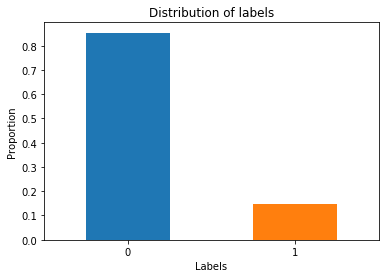

In [14]:
# check distribution of labels
fig = df['repeat_attempt_within_oneyear'].value_counts(normalize = True).plot(kind = 'bar', 
                                                                              title = 'Distribution of labels', 
                                                                              rot = 1)
fig.set(xlabel = 'Labels', ylabel = 'Proportion')

## Preprocessing 

Finally, we check for missing values. The features about income and education contain 19 missing values. Because there are only a very small number of missing values, we drop these examples and the features that were deemed to be less useful for prediction. The dataset now contains a little over 7,650 examples with almost 70 features.

In [15]:
# check missing values 
missing = df.isnull().sum(axis = 0)
pd.DataFrame({'num_missing': missing[missing != 0]})

,num_missing
dod_csrd,6241
repeat_attempt_date,6213
repeat_suicide_date,7543
repeat_attempt_1stdate,6129
comorbidity,778
income_3digit,19
education_3digit,19
ms_csrd_4cat,60


In [16]:
print(df['income_3digit'].unique()) 
print(df['education_3digit'].unique())

[ 1.  2.  3. nan]
[ 0.  1. nan]


In [17]:
# check income, education missing values
len(df[(df['income_3digit'].isnull() == True) & (df['education_3digit'].isnull() == True)].index)

19

In [18]:
# check outcome, income/education missing values overlap
df['repeat_attempt_within_oneyear'][df['income_3digit'].isnull() == True].value_counts()

0    15
1     4
Name: repeat_attempt_within_oneyear, dtype: int64

In [19]:
# check variance 
var = df.var(axis = 0)

# get features with low variance 
var[var <= .01]

mortality_before_repeat    0.000000
als_com_new                0.000000
hepa_com_new               0.000779
hepb_com_new               0.004784
hiv_com_new                0.000779
ms_com_new                 0.001038
ocd_com_new                0.004398
pd_com_new                 0.004655
tuberculosis_com_new       0.002333
mental_service_bl          0.006454
dtype: float64

In [20]:
# drop features that are not needed or have no variance 
drop_feats = date_feats + ['mortality_before_repeat', 'sex', 'scrssn', 'dod_csrd', 'oneyear_after_1stattempt', 'zip', 
                           'ms', 'ms_csrd_4cat', 'als_com_new', 'comorbidity', 'comorbidity_index', 
                           'comorbidity_index_any']
df = df.drop(drop_feats, axis = 1)
df.columns

Index(['repeat_attempt_within_oneyear', 'alcohol_com_new', 'anxiety_com_new',
       'anydem_com_new', 'bipolar_com_new', 'cancer_com_new',
       'cerebrovascular_com_new', 'chf_com_new', 'chronicpain_com_new',
       'circulatory_com_new', 'copd_com_new', 'csrdtbi_com_new',
       'csrdtbi_mild_com_new', 'csrdtbi_mod_com_new', 'depnos_com_new',
       'depression_com_new', 'dm_com_new', 'drug_com_new', 'dys_com_new',
       'epilepsy_com_new', 'gad_com_new', 'gastrointestinal_com_new',
       'hepa_com_new', 'hepatitis_com_new', 'hepb_com_new', 'hepc_com_new',
       'hiv_com_new', 'hyperten_com_new', 'liverdis_com_new',
       'major_dep_com_new', 'mi_com_new', 'mooddis_com_new', 'ms_com_new',
       'obesity_com_new', 'ocd_com_new', 'overwt_com_new', 'pain_com_new',
       'panic_com_new', 'pd_com_new', 'perdis_com_new', 'phobic_com_new',
       'pneumonia_com_new', 'psychosis_com_new', 'ptsd_com_new', 'pvd_com_new',
       'renaldis_com_new', 'schiz_com_new', 'sleepissue_com_new',

In [21]:
# drop rows with missing values
df = df.dropna(how = 'any')
all(df.isnull().sum(axis = 0) == 0)

True

In [22]:
# check dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7679 entries, 0 to 8005
Data columns (total 67 columns):
repeat_attempt_within_oneyear    7679 non-null int64
alcohol_com_new                  7679 non-null int64
anxiety_com_new                  7679 non-null int64
anydem_com_new                   7679 non-null int64
bipolar_com_new                  7679 non-null int64
cancer_com_new                   7679 non-null int64
cerebrovascular_com_new          7679 non-null int64
chf_com_new                      7679 non-null int64
chronicpain_com_new              7679 non-null int64
circulatory_com_new              7679 non-null int64
copd_com_new                     7679 non-null int64
csrdtbi_com_new                  7679 non-null int64
csrdtbi_mild_com_new             7679 non-null int64
csrdtbi_mod_com_new              7679 non-null int64
depnos_com_new                   7679 non-null int64
depression_com_new               7679 non-null int64
dm_com_new                       7679 non-nul

In [23]:
# write to csv 
df.to_csv('~/Desktop/repeat_suicide_attempt_cleaned_test.csv', index = False)